In [1]:
import os
from os.path import expanduser
home = expanduser("~/")

import sys
# sys.path.insert(0, '/global/u2/x/xshuang/gigalens-xh-dev/src')
sbalta01_dev = False

if sbalta01_dev:
    sys.path.insert(0, home+'/gigalens-sbalta01-dev'+'/src')
    print('DEVELOPER MODE')

else:
    sys.path.insert(0, home+'/gigalens'+'/src')
    print('MASTER BRANCH GIGALENS')

srcdir = os.path.join(home, "gigalens/src/")

import jax
print(jax.devices())



MASTER BRANCH GIGALENS
[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic, shapelets
from gigalens.jax.profiles.mass import epl, shear
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
import os
import yaml
np.random.seed(23)

from helpers import params_jax_to_lists, params_lists_to_jax

save_dir = "SystemSaves"

tfd = tfp.distributions

/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
kernel = np.load(os.path.join(srcdir, 'gigalens/assets/psf.npy')).astype(np.float32)

In [12]:
#* Why use two mass profiles? (EPL, Shear)
# PhysicalModel(*list of mass profiles*, *list of lens light profiles*, *list of source light profiles*)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])

# Supersampling factor is the factor by which the simulation's resolution is higher than the final image's
# What is the kernel (PSF) about? Why use that?
# SimulatorConfig(*angular size of a pixel*, *size of image*, *supersampling factor (see above)*, *point spread function to convolve images with*)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=80, supersample=2, kernel=kernel)

#* LensSimulator does most of the work, putting the models together and running simulation
lens_sim = LensSimulator(phys_model, sim_config, bs=4)

In [5]:
#* Param structure is as follows
# params = (
#     [*dict of 1st lens mass profile params*, ..., *dict of nth mass profile params*],
#     [*dict of 1st lens light profile params*, ...],
#     [*dict of 1st source light profile params*, ...]
# )
# Each dictionary's keys are the names of profiles' parameters, and the values are 
# a list of the corresponding parameters' value for each lensing system in the batch
# EXAMPLE: params[1][0]['R_sersic'][2] is the 1st lens light profile's sersic radius for the 3rd
#          lensing system to be modelled in the batch.

#* Does this mean you can't put lensing systems with different numbers of lens
#* mass profiles (for example) in the same batch? I think it does. 
#* Or maybe you can just zero out some of the parameters

params = ([
    {'theta_E': np.array([1.73, 1.35, 1.32, 1.51]), 
     'gamma': np.array([2.5, 2.21, 1.8, 2.34]), 
     'e1': np.array([0, 0, 0.127, 0.05]), 
     'e2': np.array([0.169, 0.1, 0.058, 0.05]), 
     'center_x': np.array([0, 0, 0, 0]), 
     'center_y': np.array([0, 0, 0, 0])},
    {'gamma1': np.array([0, 0.07, 0.02, 0.071]), 
     'gamma2': np.array([0.16, 0, 0.00, 0.071])}
    
], [{'R_sersic': np.array([0.91, 2, 1.5, 1.5]), 
     'n_sersic': np.array([1.5, 3, 4, 4]), 
     'e1': np.array([0, 0, 0.05, 0.05]), 
     'e2': np.array([0.169, 0.1, 0.05, 0.05]), 
     'center_x': np.array([0, 0, 0, 0]), 
     'center_y': np.array([0, 0, 0, 0]), 
     'Ie': np.array([80, 40, 50, 20])}], #1st ie used to be 80
    
    [{'R_sersic': np.array([0.1, 0.1, 0.2, 0.15]), 
      'n_sersic': np.array([1.5, 1.5, 1, 1]), 
      'e1': np.array([0.1, 0, 0., 0.3]), 
      'e2': np.array([0, 0, 0.1, 0.3]), 
      'center_x': np.array([-0.16, 0.08, 0.01, 0.2]), 
      'center_y': np.array([0, 0.22, -0.01, -0.2]), 
      'Ie': np.array([620.142, 700, 550, 550])}])

In [6]:
import lenstronomy.Util.image_util as image_util

def noise_images(imgs, exp_time=100, background_rms=0.2):
    noised_images = []
    #* Add noise
    for lens_img in imgs:
        poisson = image_util.add_poisson(lens_img, exp_time=exp_time)
        bkg = image_util.add_background(lens_img, sigma_bkd=background_rms) # gaussian, mean is 0
        noised_images.append(lens_img + poisson + bkg) 

    return noised_images

In [19]:
sim_lenses = lens_sim.simulate(params)
unlensed_source = lens_sim.simulate([[], [], params[2]])

noised_archetypal = noise_images(sim_lenses)

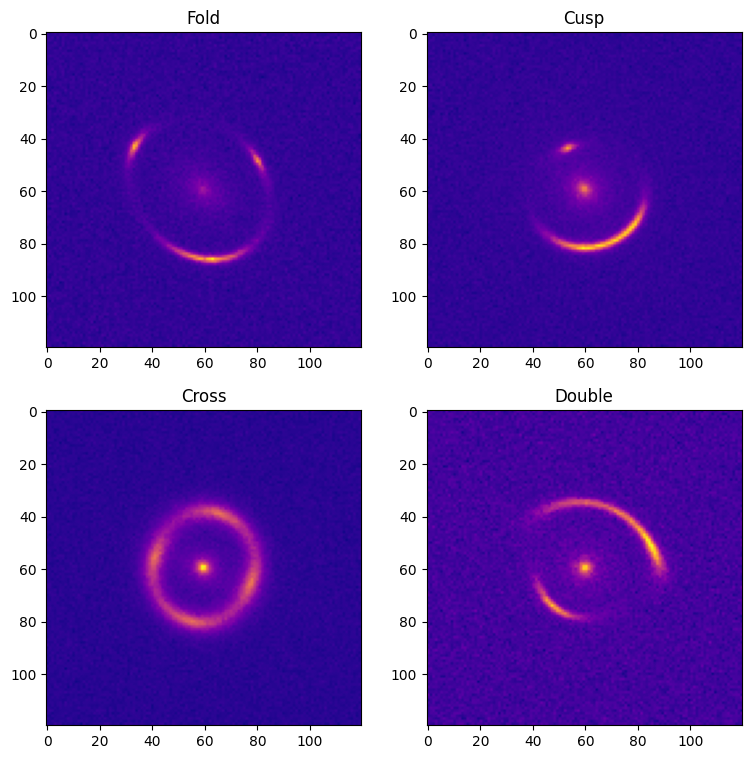

In [20]:
titles = ["Fold", "Cusp", "Cross", "Double"]
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(9, 9)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noised_archetypal[i], cmap="plasma")
    ax.set_title(titles[i])
plt.show()

In [21]:
save_dict = dict(zip(titles, noised_archetypal))
np.savez(os.path.join(save_dir, "FourArchetypal"), **save_dict)


filename = os.path.join(save_dir, 'FourArchetypalParams.pkl')
with open(filename, 'wb') as file:
    pickle.dump(params, file)

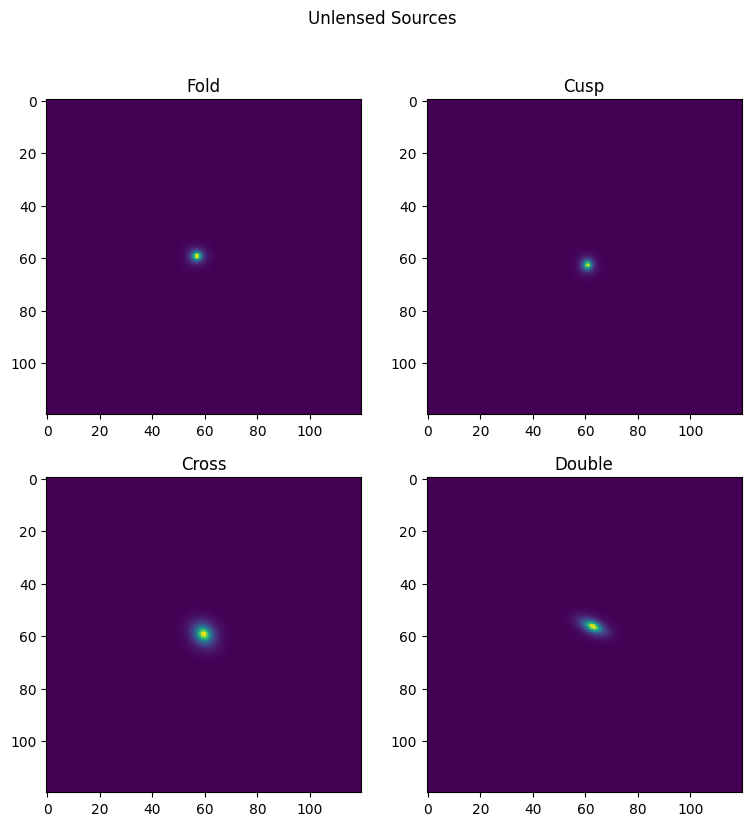

In [22]:
titles = ["Fold", "Cusp", "Cross", "Double"]
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(9, 9)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(unlensed_source[i])
    ax.set_title(titles[i])
fig.suptitle("Unlensed Sources")
plt.show()

In [7]:
#* Initialize Priors
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.6), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.05, -0.15, 0.15),
                e2=tfd.TruncatedNormal(0, 0.05, -0.15, 0.15),
                center_x=tfd.Normal(0, 0.01),
                center_y=tfd.Normal(0, 0.01),
                Ie=tfd.LogNormal(jnp.log(300.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [13]:
from jax import random
# hundred_params = prior.sample(100, seed=random.PRNGKey(0))

with open(os.path.join(save_dir, '100SystemsStandardParams.yaml'), 'r') as file:
    hundred_params = params_lists_to_jax(yaml.safe_load(file))

In [14]:
lens_sim_large_batch = LensSimulator(phys_model, sim_config, bs=100)
import time
startTime = time.time()
many_sim_lenses = lens_sim_large_batch.simulate(hundred_params)
duration = time.time() - startTime

hundred_noised = noise_images(many_sim_lenses)
print(f"Simulation: {duration/100 * 1000} ms per system.")

Simulation: 33.04377317428589 ms per system.


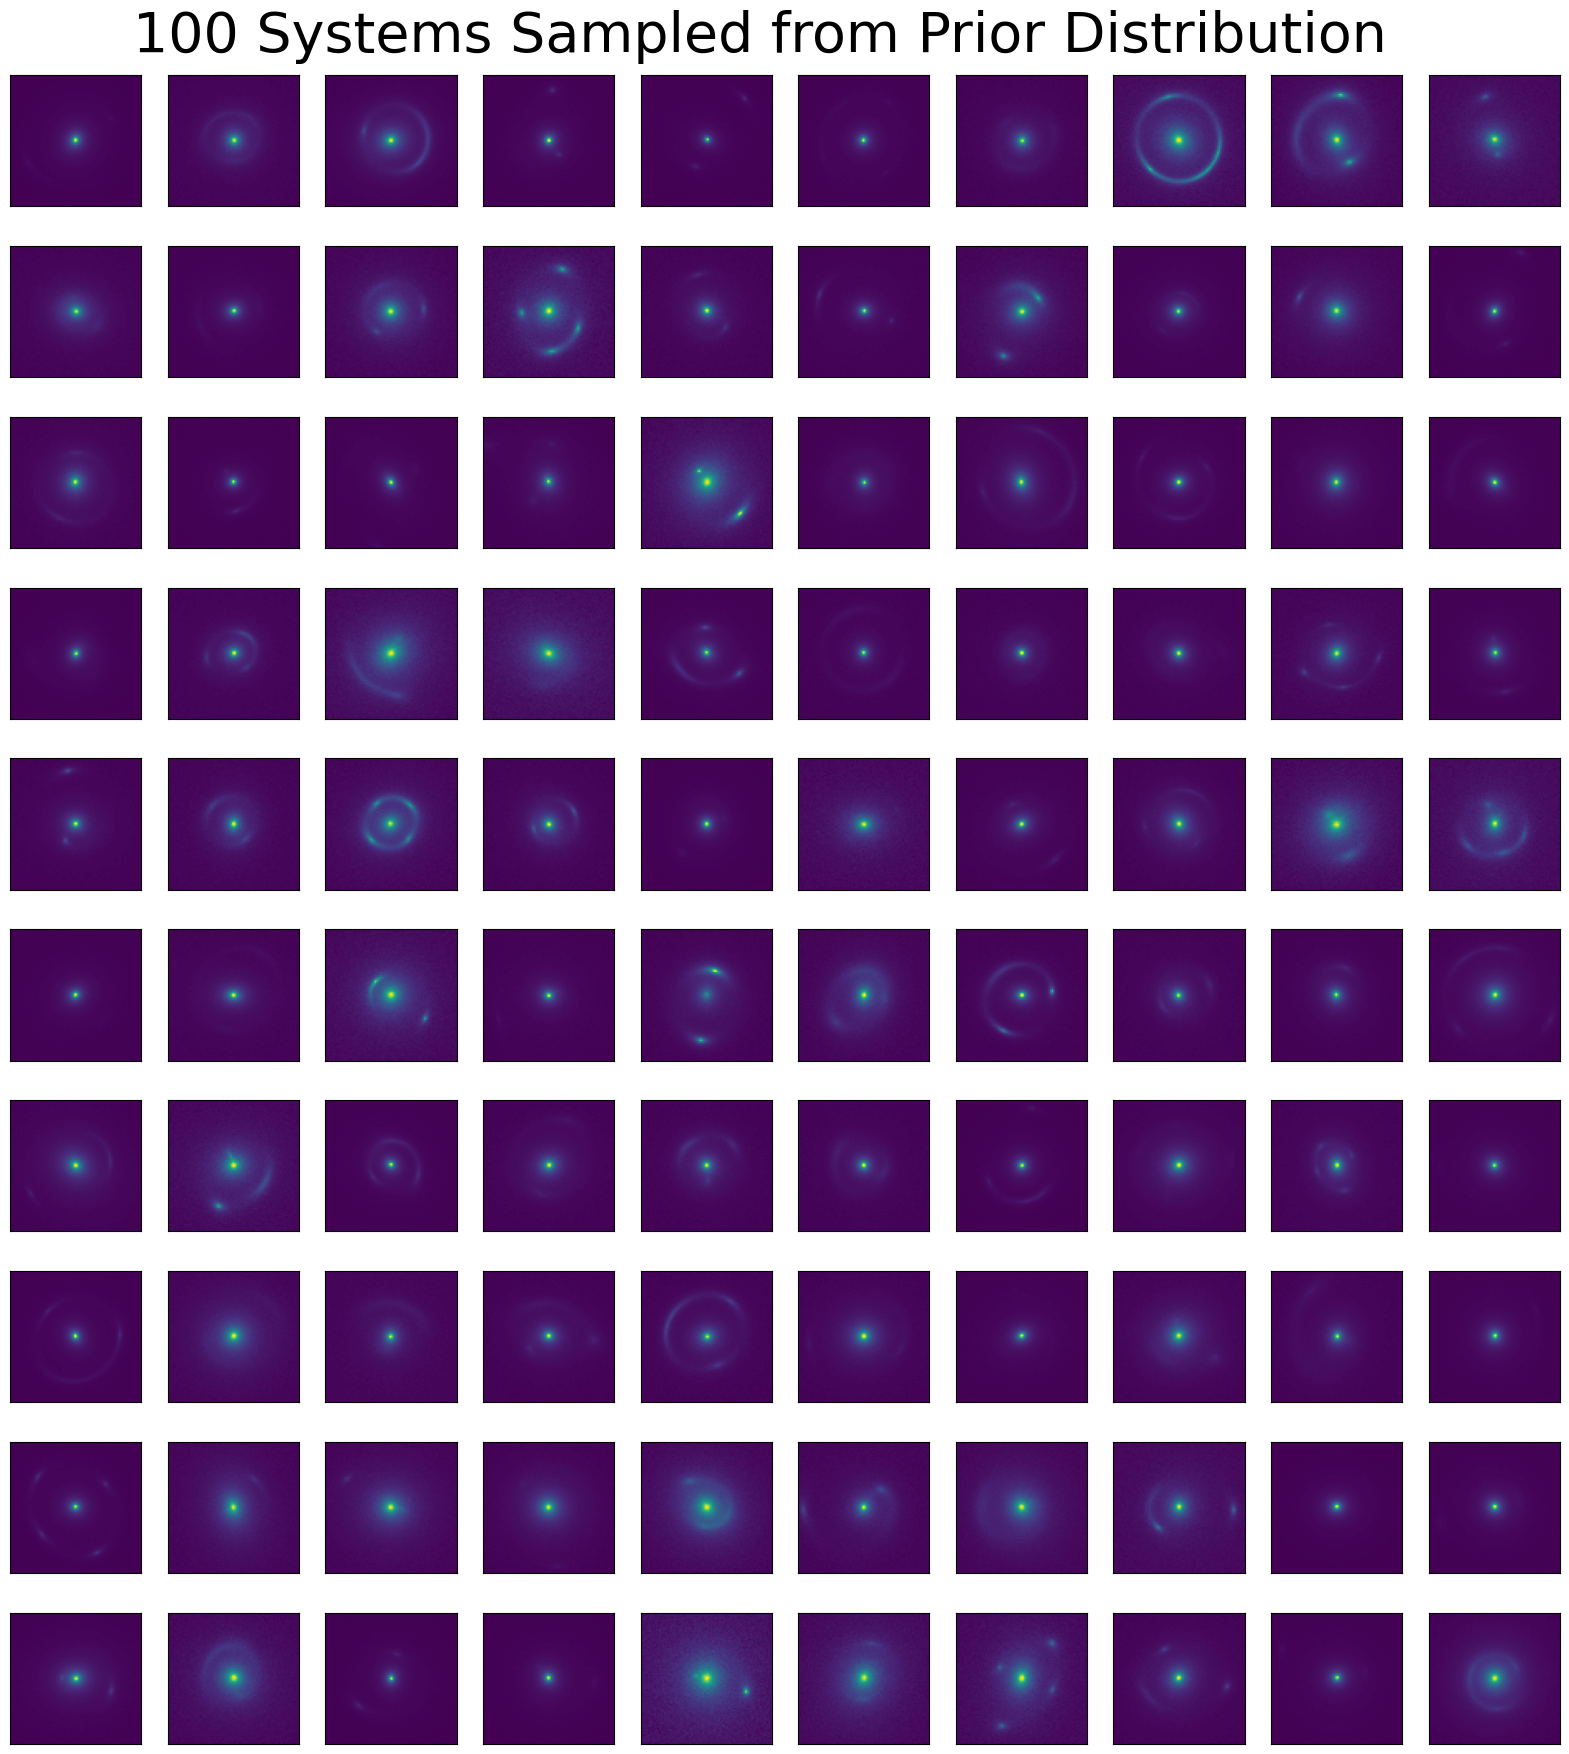

In [15]:
fig, axs = plt.subplots(10, 10)
fig.set_size_inches(20, 20)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(hundred_noised[i])

    ax.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 
fig.suptitle("100 Systems Sampled from Prior Distribution", fontsize=40)
plt.subplots_adjust(top=0.95)
plt.show()

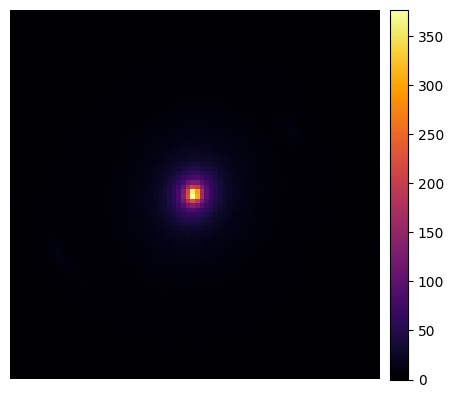

In [17]:
from helpers import plot_image
fig, ax = plt.subplots()
plot_image(fig, ax, hundred_noised[0])
plt.show()

In [18]:
hundred_noised[0].shape

(80, 80)

In [16]:
save_dict = dict(zip([f"sys_{i}" for i in range(100)], hundred_noised))
np.savez(os.path.join(save_dir, "100SystemsStandard80px"), **save_dict)

filename = os.path.join(save_dir, '100SystemsStandardParams.yaml')
with open(filename, 'w') as file:
    yaml.dump(params_jax_to_lists(hundred_params), file)
# with open(filename, 'wb') as file:
#     pickle.dump(hundred_params, file)

In [17]:

with open(filename, 'r') as file:
    loaded_params_list = yaml.safe_load(file)
    
loaded_params = params_lists_to_jax(loaded_params_list)
